In [37]:
import pandas as pd
from finta import TA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,
2010-07-24,0.0545,0.0545,0.0545,0.0545,0.000000e+00,0.000000e+00
2010-07-25,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
2010-07-26,0.0560,0.0560,0.0560,0.0560,0.000000e+00,0.000000e+00
2010-07-27,0.0600,0.0600,0.0600,0.0600,0.000000e+00,0.000000e+00
2010-07-28,0.0589,0.0589,0.0589,0.0589,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2023-08-18,26659.8500,26784.2300,25721.5300,26058.2600,7.032831e+10,5.115170e+11
2023-08-19,26069.2300,26253.2600,25814.2500,26090.6300,4.769626e+10,5.060530e+11
2023-08-20,26085.1800,26267.3300,26002.0300,26180.0000,3.624048e+10,5.084380e+11


In [3]:
# Calculate ADX
df['ADX'] = TA.ADX(df)

# Calculate RSI
df['RSI'] = TA.RSI(df)

# Calculate Bollinger Bands
bollinger_bands = TA.BBANDS(df)
df['BollingerUpper'] = bollinger_bands['BB_UPPER']
df['BollingerMiddle'] = bollinger_bands['BB_MIDDLE']
df['BollingerLower'] = bollinger_bands['BB_LOWER']

df.dropna(inplace=True)

In [4]:
def label_market(df, criteria):
    df['MarketLabel'] = 0
    indices = df.index.tolist()
    
    for i in range(len(indices)):
        current_index = indices[i]
        trendy_count = 0
        
        if df.loc[current_index, 'ADX'] > 25:
            trendy_count += 1
        
        if df.loc[current_index, 'RSI'] < 30 or df.loc[current_index, 'RSI'] > 70:
            trendy_count += 1

        if i > 0:
            previous_index = indices[i-1]
            current_width = df.loc[current_index, 'BollingerUpper'] - df.loc[current_index, 'BollingerLower']
            previous_width = df.loc[previous_index, 'BollingerUpper'] - df.loc[previous_index, 'BollingerLower']
            
            if current_width > previous_width:
                trendy_count += 1

        if trendy_count >= criteria:
            df.loc[current_index, 'MarketLabel'] = 1  # Trendy
            
    return df

In [5]:
def plot_colored_market_trends(df):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for date, row in df.iterrows():
        current_price = row['Close']
        current_label = row['MarketLabel']
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [6]:
df.head(30)
df=label_market(df,2)

In [7]:
df.tail(30)

,Open,High,Low,Close,Volume,Market Cap,ADX,RSI,BollingerUpper,BollingerMiddle,BollingerLower,MarketLabel
Start,,,,,,,,,,,,
2023-07-24,30076.96,30087.98,28945.60,29186.08,4.655449e+10,5.719480e+11,33.401285,42.331972,31055.095179,30175.7175,29296.339821,1
2023-07-25,29177.63,29330.03,29053.27,29242.03,4.605612e+10,5.670650e+11,31.137863,43.056460,31070.567393,30112.6730,29154.778607,1
2023-07-26,29217.21,29661.48,29131.02,29349.52,3.667730e+10,5.690620e+11,29.761994,44.499070,31097.440328,30081.6465,29065.852672,1
2023-07-27,29337.96,29555.75,29100.73,29209.65,4.036667e+10,5.705130e+11,28.393929,42.973452,31106.392501,30026.1270,28945.861499,1
2023-07-28,29214.02,29510.07,29126.05,29318.62,4.063137e+10,5.688140e+11,27.123582,44.567946,31096.832145,29978.6070,28860.381855,1
2023-07-29,29305.34,29397.16,29264.46,29356.22,3.348051e+10,5.699740e+11,25.943975,45.137957,31086.159993,29938.1935,28790.227007,1
2023-07-30,29355.01,29442.05,29105.61,29273.90,2.651967e+10,5.696780e+11,24.215428,44.069486,31045.124362,29881.9835,28718.842638,0
2023-07-31,29285.32,29496.64,29134.91,29225.93,3.449781e+10,5.703100e+11,22.820956,43.424421,30955.816105,29812.2020,28668.587895,0
2023-08-01,29226.01,29629.24,28778.21,29629.24,4.149923e+10,5.642470e+11,22.108071,50.045036,30888.073966,29774.4715,28660.869034,0


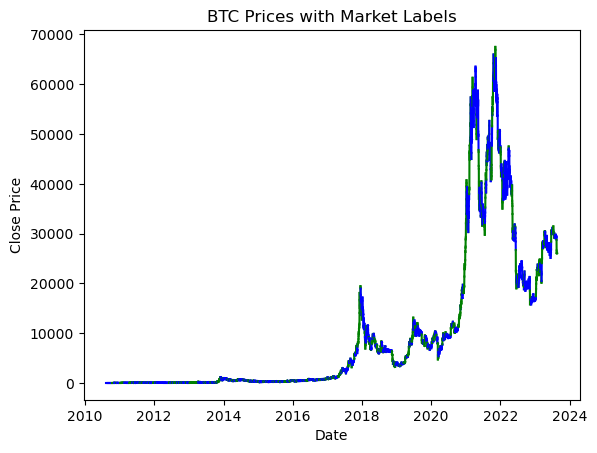

In [8]:
plot_colored_market_trends(df)

In [9]:
df['MarketLabel'].value_counts()

0    2922
1    1837
Name: MarketLabel, dtype: int64

In [10]:
X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

In [11]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [12]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model 

In [13]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred)

[0 0 0 ... 0 0 1]


In [14]:
accuracy_score(y_test, svm_pred)

0.8327731092436975

In [15]:
# Generate a confusion matrix for the model

confusion_matrix(y_test, svm_pred)

array([[712,  30],
       [169, 279]], dtype=int64)

In [16]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       742
           1       0.90      0.62      0.74       448

    accuracy                           0.83      1190
   macro avg       0.86      0.79      0.81      1190
weighted avg       0.84      0.83      0.82      1190



In [17]:
# gradient bosting - Haywar 
# neural network - Nariman 
# logistic regressionaccuracy_score(y_test, predictions) - Ramees 
# random forest - Ramees 
# LSM models  - Vishnu 


# GB Model 

In [18]:
# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_clf.fit(X_train_scaled, y_train)

# Predict the labels
y_pred = gb_clf.predict(X_test_scaled)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       742
           1       0.90      0.72      0.80       448

    accuracy                           0.86      1190
   macro avg       0.87      0.83      0.85      1190
weighted avg       0.87      0.86      0.86      1190



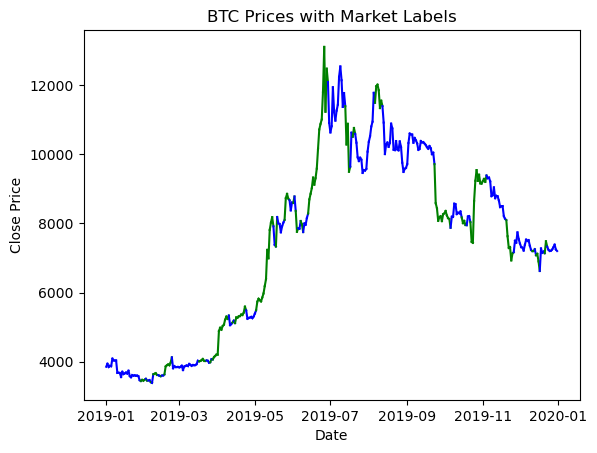

In [19]:
filtered_df = df['2019-01-01':'2019-12-31']
plot_colored_market_trends(filtered_df)

## Logistics Regression

In [20]:

lg_model = LogisticRegression(random_state=1)  

# Fit the model using training data
lg_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [21]:
lg_predictions = lg_model.predict(X_test_scaled)

In [22]:
accuracy_score(y_test, lg_predictions)

0.6890756302521008

In [23]:
confusion_matrix(y_test, lg_predictions)

array([[630, 112],
       [258, 190]], dtype=int64)

In [24]:
print(classification_report(y_test, lg_predictions))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       742
           1       0.63      0.42      0.51       448

    accuracy                           0.69      1190
   macro avg       0.67      0.64      0.64      1190
weighted avg       0.68      0.69      0.67      1190



## Random Forest 

In [25]:
rf_model = RandomForestClassifier(random_state=1)

# Fit the model using training data
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1)

In [26]:
rf_predictions = rf_model.predict(X_test_scaled)

In [27]:
accuracy_score(y_test, rf_predictions)

0.8873949579831932

In [28]:
confusion_matrix(y_test, rf_predictions)

array([[693,  49],
       [ 85, 363]], dtype=int64)

In [29]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       742
           1       0.88      0.81      0.84       448

    accuracy                           0.89      1190
   macro avg       0.89      0.87      0.88      1190
weighted avg       0.89      0.89      0.89      1190



## LSTM

In [30]:
nn = Sequential()

# Creating the first hidden layer
nn.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train_scaled.shape[1],1)))
nn.add(Dropout(0.2))

# Creating the second hidden layer
nn.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the third hidden layer
nn.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the fourth hidden layer
nn.add(LSTM(units = 60, activation = 'relu'))
nn.add(Dropout(0.1))

# Creating the output layer to the model 
nn.add(Dense(units = 1, activation= 'sigmoid'))


In [31]:
# Display the LSTM model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 11, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 11, 60)            31440     
                                                                 
 dropout_1 (Dropout)         (None, 11, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 11, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 11, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [32]:
# Compile the model
nn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [33]:
# Fit the model with the scaled train data and corresponding lables with 50 epochs
nn.fit(X_train_scaled, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
112/112 [==============================] - 22s 55ms/step - loss: 0.2378 - accuracy: 0.6094
Epoch 2/50
112/112 [==============================] - 6s 55ms/step - loss: 0.2246 - accuracy: 0.6243
Epoch 3/50
112/112 [==============================] - 6s 54ms/step - loss: 0.2076 - accuracy: 0.6918
Epoch 4/50
112/112 [==============================] - 6s 55ms/step - loss: 0.2016 - accuracy: 0.6985
Epoch 5/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1979 - accuracy: 0.7083
Epoch 6/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1941 - accuracy: 0.7142
Epoch 7/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1908 - accuracy: 0.7249
Epoch 8/50
112/112 [==============================] - 6s 54ms/step - loss: 0.1839 - accuracy: 0.7386
Epoch 9/50
112/112 [==============================] - 6s 54ms/step - loss: 0.1797 - accuracy: 0.7450
Epoch 10/50
112/112 [==============================] - 6s 55ms/step - loss: 0.1777 - accur

In [34]:
# Display the prdictions by the model on the test data
pred = nn.predict(X_test_scaled)

# convert predictions to binary and required data structure
lstm_pred= np.where(pred > 0.5, 1, 0).ravel()
lstm_pred

38/38 [==============================] - 3s 19ms/step


array([0, 0, 0, ..., 0, 0, 1])

In [35]:
# Obtain the classification report of the predictions
print(classification_report(y_test, lstm_pred))


              precision    recall  f1-score   support

           0       0.82      0.94      0.88       742
           1       0.87      0.65      0.74       448

    accuracy                           0.83      1190
   macro avg       0.84      0.80      0.81      1190
weighted avg       0.84      0.83      0.83      1190



## Neural Network

In [38]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
90/90 [==============================] - 1s 5ms/step - loss: 0.5951 - accuracy: 0.6722 - val_loss: 0.5213 - val_accuracy: 0.7227
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 0.5064 - accuracy: 0.7285 - val_loss: 0.4579 - val_accuracy: 0.7843
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.4525 - accuracy: 0.7744 - val_loss: 0.4125 - val_accuracy: 0.7927
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.4107 - accuracy: 0.7930 - val_loss: 0.3839 - val_accuracy: 0.8165
Epoch 5/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3994 - accuracy: 0.8053 - val_loss: 0.3813 - val_accuracy: 0.8151
Epoch 6/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3888 - accuracy: 0.8084 - val_loss: 0.3742 - val_accuracy: 0.8137
Epoch 7/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3798 - accuracy: 0.8151 - val_loss: 0.3680 - val_accuracy: 0.8193
Epoch 8/50
90/90 [==

In [44]:
# Obtaining the predictions
nn_pred = model.predict(X_test_scaled)
nn_pred = np.where(nn_pred > 0.5, 1, 0).ravel()
nn_pred

38/38 [==============================] - 0s 2ms/step


array([0, 0, 1, ..., 0, 0, 1])

In [45]:
# Creating the classification report
print(classification_report(y_test, nn_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       742
           1       0.88      0.67      0.76       448

    accuracy                           0.84      1190
   macro avg       0.85      0.81      0.82      1190
weighted avg       0.85      0.84      0.84      1190

